# Mandelbrot in Mojo, Plotting in Python

Not only Mojo is great for writing high-performance code, but it also allows us to leverage huge Python ecosystem of libraries and tools. With seamless Python interoperability, Mojo can use Python for what it's good at, especially GUIs, without sacrificing performance in critical code. Let's take the classic Mandelbrot set algorithm and implement it in Mojo.

We'll introduce a `Complex` type and use it in our implementation.

In [1]:
from DType import DType
from Memory import memset_zero
from Object import object, Attr
from Pointer import DTypePointer, Pointer
from Random import rand
from Range import range
from SIMD import SIMD, SI64, F64, F32
from TargetInfo import dtype_sizeof
from Complex import ComplexSIMD as ComplexGenericSIMD


In [2]:
struct Matrix:
    var data: DTypePointer[DType.si64]
    var rows: Int
    var cols: Int
    var rc: Pointer[Int]

    fn __init__(self&, cols: Int, rows: Int):
        self.data = DTypePointer[DType.si64].alloc(rows * cols)
        self.rows = rows
        self.cols = cols
        self.rc = Pointer[Int].alloc(1)
        self.rc.store(1)

    fn __copyinit__(self&, other: Self):
        other._inc_rc()
        self.data = other.data
        self.rc   = other.rc
        self.rows = other.rows
        self.cols = other.cols

    fn __del__(owned self):
        self._dec_rc()

    fn _get_rc(self) -> Int:
        return self.rc.load()

    fn _dec_rc(self):
        let rc = self._get_rc()
        if rc > 1:
            self.rc.store(rc - 1)
            return
        self._free()

    fn _inc_rc(self):
        let rc = self._get_rc()
        self.rc.store(rc + 1)

    fn _free(self):
        self.data.free()
        self.rc.free()

    fn zero(self&):
        memset_zero(self.data, self.rows * self.cols * dtype_sizeof[DType.si64]())

    @always_inline
    fn __getitem__(self, x: Int, y: Int) -> SI64:
        return self.load[1](x, y)

    @always_inline
    fn load[nelts:Int](self, x: Int, y: Int) -> SIMD[DType.si64, nelts]:
        return self.data.simd_load[nelts](y * self.cols + x)

    @always_inline
    fn __setitem__(self, x: Int, y: Int, val: SI64):
        return self.store[1](x, y, val)

    @always_inline
    fn store[nelts:Int](self, x: Int, y: Int, val: SIMD[DType.si64, nelts]):
        self.data.simd_store[nelts](y * self.cols + x, val)

    def to_numpy(self) -> PythonObject:
        let np = Python.import_module("numpy")
        let numpy_array = np.zeros((self.rows, self.cols), np.uint32)
        for x in range(self.cols):
            for y in range(self.rows):
                numpy_array.itemset((y, x), self[x, y].cast[DType.f32]())
        return numpy_array

In [3]:
@register_passable("trivial")
struct Complex:
    var real: F32
    var imag: F32

    fn __init__(real: F32, imag: F32) -> Self:
        return Self {real: real, imag: imag}

    fn __add__(lhs, rhs: Self) -> Self:
        return Self(lhs.real + rhs.real, lhs.imag + rhs.imag)

    fn __mul__(lhs, rhs: Self) -> Self:
        return Self(
            lhs.real * rhs.real - lhs.imag * rhs.imag,
            lhs.real * rhs.imag + lhs.imag * rhs.real,
        )

    fn norm(self) -> F32:
        return self.real * self.real + self.imag * self.imag

Then we can write the core Mandelbrot algorithm, which involves computing an iterative complex function for each pixel until it "escapes" the complex circle of radius 2, counting the number of iterations to escape.

$$z_{i+1} = z_i^2 + c$$

In [4]:
alias xmin: F32 = -2.25
alias xmax: F32 = 0.75
alias xn = 1500
alias ymin: F32 = -1.25
alias ymax: F32 = 1.25
alias yn = 1250

# Compute the number of steps to escape.
def mandelbrot_kernel(c: Complex) -> Int:
    max_iter = 200
    z = c
    for i in range(max_iter):
        z = z * z + c
        if z.norm() > 4:
            return i
    return max_iter


def compute_mandelbrot() -> Matrix:
    # create a matrix. Each element of the matrix corresponds to a pixel
    result = Matrix(xn, yn)

    dx = (xmax - xmin) / xn
    dy = (ymax - ymin) / yn

    x = xmin
    for i in range(xn):
        y = ymin
        for j in range(yn):
            result[i, j] = mandelbrot_kernel(Complex(x, y))
            y += dy
        x += dx
    return result

Plotting the number of iterations to escape with some color gives us the canonical Mandelbrot set plot. To render it we can directly leverage Python's `matplotlib` right from Mojo!

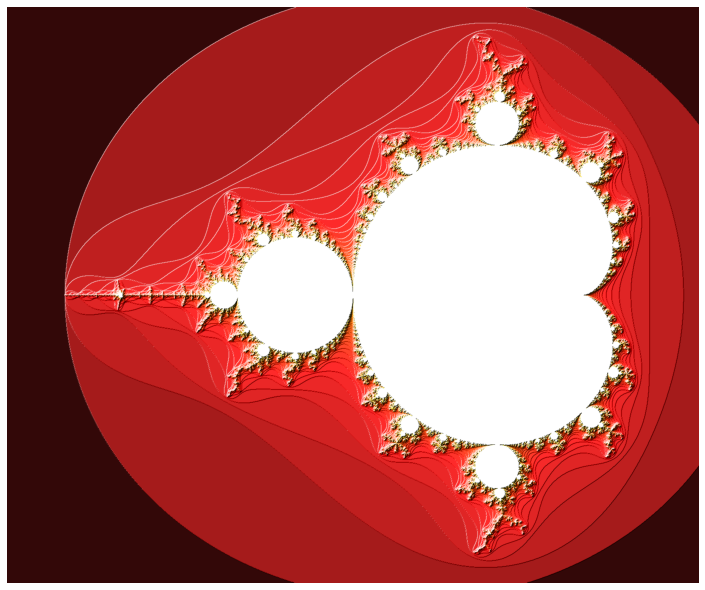


finished


In [5]:
def make_plot(m: Matrix):
    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")
    colors = Python.import_module("matplotlib.colors")
    dpi = 72
    width = 10
    height = 10 * yn // xn

    fig = plt.figure(1, [width, height], dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)

    light = colors.LightSource(315, 10, 0, 1, 1, 0)

    image = light.shade(m.to_numpy(), plt.cm.hot, colors.PowerNorm(0.3), "hsv", 0, 0, 1.5)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

make_plot(compute_mandelbrot())
#| CHECK: finished
print("finished")

## Vectorizing Mandelbrot

We showed a naive implementation of the Mandelbrot algorithm, but there are two things we can do to speed it up. We can early-stop the loop iteration when a pixel is known to have escaped, and we can leverage Mojo's access to hardware by vectorizing the loop, computing multiple pixels simultaneously. To do that we will use the `vectorize` higher order generator.

We start by defining our main iteration loop in a vectorized fashion

In [6]:
fn mandelbrot_kernel_simd[simd_width:Int](c: ComplexGenericSIMD[DType.f32, simd_width]) -> SIMD[DType.si64, simd_width]:
    var z = c
    var nv = SIMD[DType.si64, simd_width](0)
    var escape_mask = SIMD[DType.bool, simd_width](0)

    var i = 100
    while i != 0 and not escape_mask:
        escape_mask = z.norm() > 4 
        z = z*z + c
        # select either nv or nv+1 depending on the mask
        nv = escape_mask.select(nv, nv + 1) 
        i -= 1
    
    return nv

The above function is parameterized on the simd_width and processes simd_width pixels. It only escapes once all pixels within the vector lane are done. We can use the same iteration loop as above, but this time we vectorize within each row instead. We use the `vectorize` generator to make this a simple function call.

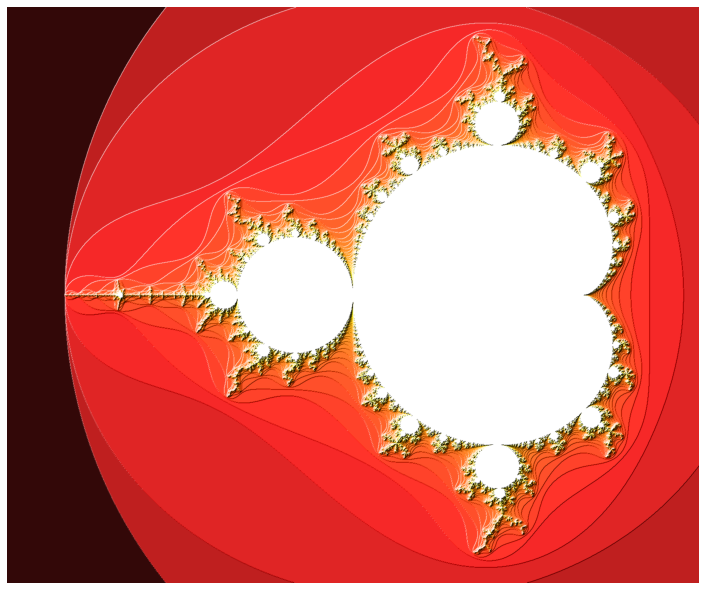


finished


In [7]:
from Functional import vectorize
from Math import iota
from TargetInfo import dtype_simd_width


def compute_mandelbrot_simd() -> Matrix:
    # create a matrix. Each element of the matrix corresponds to a pixel
    var result = Matrix(xn, yn)

    let dx = (xmax - xmin) / xn
    let dy = (ymax - ymin) / yn

    var x = xmin
    for i in range(xn):
        var y = ymin
        fn _process_simd_element[simd_width:Int](j:Int):
            let c = ComplexGenericSIMD[DType.f32, simd_width](SIMD[DType.f32, simd_width](x), 
                                                              dy*iota[simd_width, DType.f32]() + y)
            result.store[simd_width](i, j, mandelbrot_kernel_simd[simd_width](c))
            y += simd_width*dy
            
        alias simd_width = dtype_simd_width[DType.f32]()
        vectorize[1, _process_simd_element](yn)
        x += dx
    return result


make_plot(compute_mandelbrot_simd())
#| CHECK: finished
print("finished")

## Parallelizing Mandelbrot

While the vectorized implementation above is efficient, we can get better performance by parallelizing on the rows. This again is simple in Mojo using the `parallelize` higher order function. Only the function that performs the invocation needs to change.

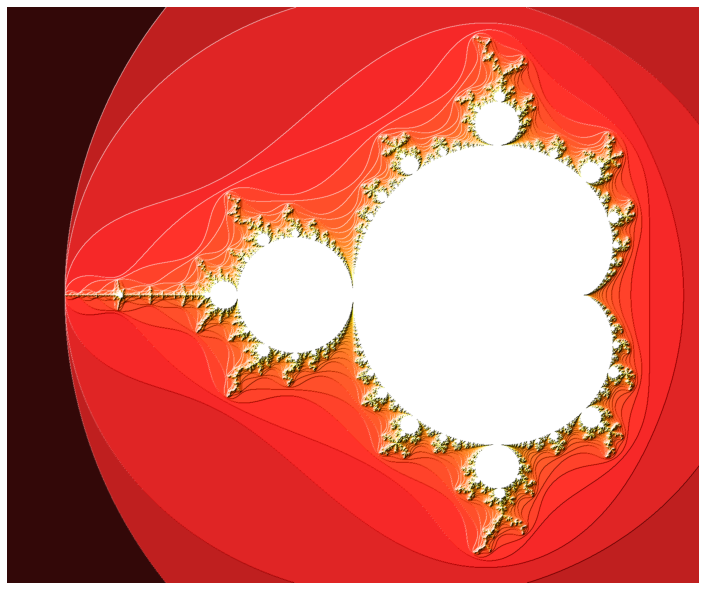


finished


In [8]:
from Functional import parallelize 

def compute_mandelbrot_simd_parallel() -> Matrix:
    # create a matrix. Each element of the matrix corresponds to a pixel
    var result = Matrix(xn, yn)

    let dx = (xmax - xmin) / xn
    let dy = (ymax - ymin) / yn

    fn _process_row(i:Int):
        var x = xmin + dx*i
        var y = ymin
        fn _process_simd_element[simd_width:Int](j:Int):
            let c = ComplexGenericSIMD[DType.f32, simd_width](SIMD[DType.f32, simd_width](x), 
                                                              dy*iota[simd_width, DType.f32]() + y)
            result.store[simd_width](i, j, mandelbrot_kernel_simd[simd_width](c))
            y += simd_width*dy
            
        alias simd_width = dtype_simd_width[DType.f32]()
        vectorize[1, _process_simd_element](yn)
    
    parallelize[_process_row](xn)
    return result


make_plot(compute_mandelbrot_simd_parallel())
#| CHECK: finished
print("finished")